In [1]:
import sys
sys.path.append('../scripts')
%load_ext autoreload
%autoreload 2


In [2]:
from experience_analytics import analyze_customer_experience
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML
import pandas as pd


### Get the data

In [3]:
results = analyze_customer_experience()
df = results['processed_data']

Connected to the database


c:\Users\Kalea\Desktop\week-2\notebooks\../scripts\load_data.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(query, conn)


Data loaded successfully
Database connection closed


c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106857 entries, 0 to 106856
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   msisdn                106856 non-null  float64
 1   handset_manufacturer  106857 non-null  object 
 2   handset_type          106857 non-null  object 
 3   tcp_retrans_rate      106857 non-null  float64
 4   avg_rtt               106857 non-null  float64
 5   avg_throughput        106857 non-null  float64
 6   cluster               106857 non-null  int32  
dtypes: float64(4), int32(1), object(2)
memory usage: 5.3+ MB


In [5]:
distribution_stats = results['distribution_stats']
handset_metrics = results['handset_metrics']

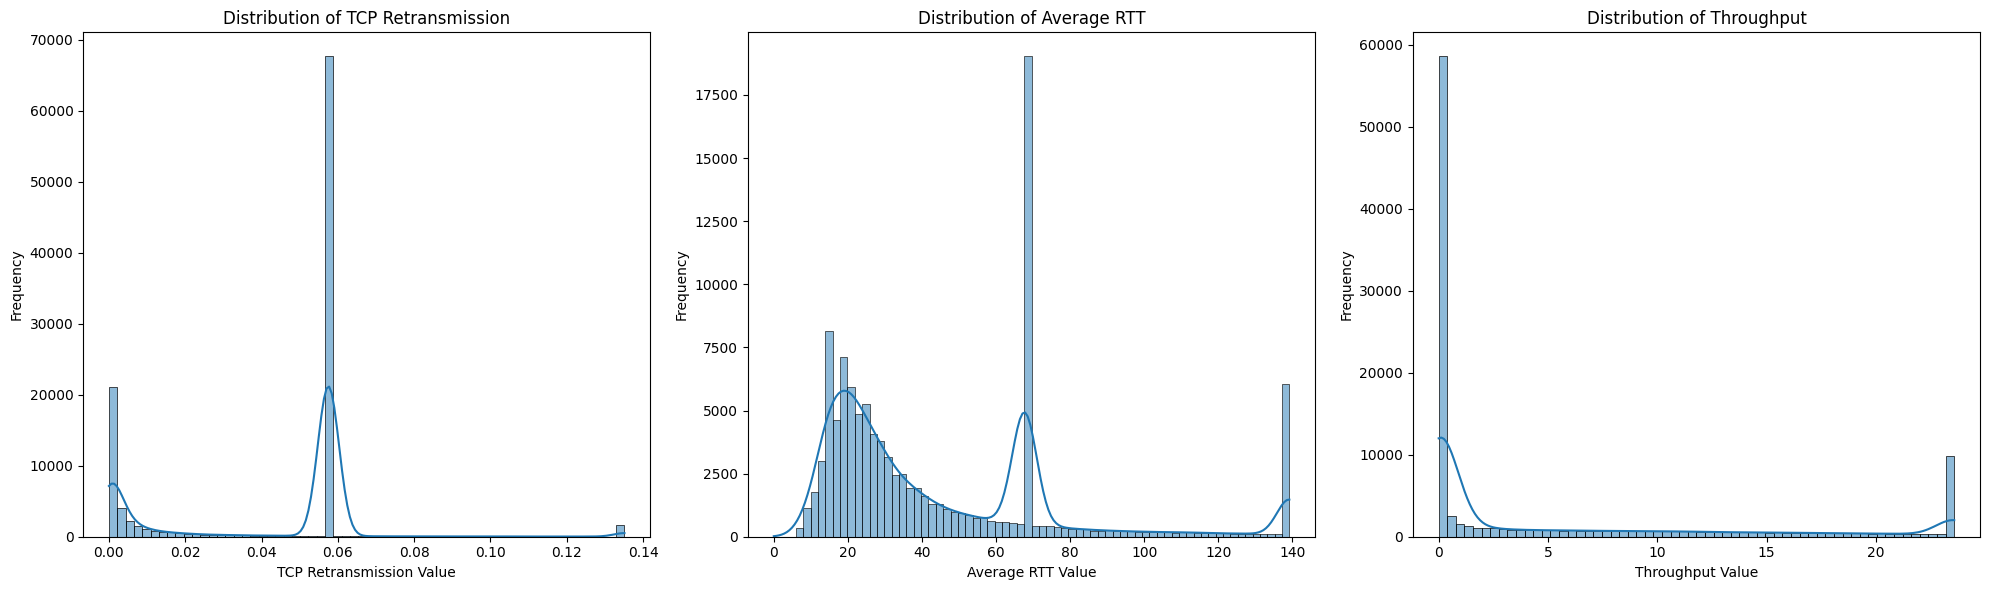

In [6]:
# 1. Distribution Analysis
metrics = ['tcp_retrans_rate', 'avg_rtt', 'avg_throughput']
titles = ['TCP Retransmission', 'Average RTT', 'Throughput']

# Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for ax, metric, title in zip(axes, metrics, titles):
    sns.histplot(data=df, x=metric, ax=ax, kde=True)
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel(f'{title} Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [7]:
# Print distribution statistics
table_data = []
for metric in metrics:
   stats = {
       'Metric': metric,
       'Top 10 Values': str(distribution_stats[metric]['top_n']),
       'Bottom 10 Values': str(distribution_stats[metric]['bottom_n']),
       'Most Frequent Values': str(distribution_stats[metric]['most_frequent'])
   }
   table_data.append(stats)
stats_df = pd.DataFrame(table_data)
display(stats_df.style.set_properties(**{
   'white-space': 'pre-wrap',
   'text-align': 'left'
}).set_table_styles([
   {'selector': 'th', 'props': [('text-align', 'left'), ('background-color', '#f2f2f2')]},
   {'selector': 'td', 'props': [('max-width', '300px')]}
]))


,Metric,Top 10 Values,Bottom 10 Values,Most Frequent Values
0,tcp_retrans_rate,"[0.13512270033831975, 0.13512270033831975, 0.13512270033831975, 0.13512270033831975, 0.13512270033831975, 0.13512270033831975, 0.13512270033831975, 0.13512270033831975, 0.13512270033831975, 0.13512270033831975]","[8.199949103133614e-08, 1.0587048572416535e-07, 1.201662179227491e-07, 1.3144436259837328e-07, 1.4326941215070457e-07, 1.583276395200157e-07, 1.589921152983497e-07, 1.632177596903267e-07, 1.6612498219508405e-07, 1.7955123894074145e-07]","[0.057521828908135945, 0.13512270033831975, 0.015455660530723328, 0.001243056921240928, 0.0007273481512372425, 0.0027840687284506126, 0.022909801144871296, 4.425542313786669e-05, 0.00773976465867637, 4.728195805164223e-05]"
1,avg_rtt,"[139.1940094963624, 139.1940094963624, 139.1940094963624, 139.1940094963624, 139.1940094963624, 139.1940094963624, 139.1940094963624, 139.1940094963624, 139.1940094963624, 139.1940094963624]","[0.0, 0.0, 1.0, 2.0, 2.5, 3.0, 4.0, 4.5, 4.5, 5.0]","[67.67760379854496, 139.1940094963624, 14.5, 19.5, 19.0, 20.0, 15.0, 14.0, 24.5, 20.5]"
2,avg_throughput,"[23.588500000000003, 23.588500000000003, 23.588500000000003, 23.588500000000003, 23.588500000000003, 23.588500000000003, 23.588500000000003, 23.588500000000003, 23.588500000000003, 23.588500000000003]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[23.588500000000003, 0.0075, 0.0315, 0.0485, 0.045, 0.049, 0.048, 0.0495, 0.0445, 0.0455]"


In [8]:
# Print handset statistics
for metric in metrics:
    print(f"\n{metric.upper()} by Handset Type:")
    print("-" * 50)
    print(handset_metrics[metric])



TCP_RETRANS_RATE by Handset Type:
--------------------------------------------------
                                                                          mean  \
handset_manufacturer             handset_type                                    
Huawei                           Huawei Bln-Al10                      0.135123   
Samsung                          Samsung Galaxy J8 2018               0.135123   
Spa Condor Electronics           Spa Condor Elect. Allure M1 Plus     0.135123   
ASUSTeK                          Asustek Asus Zenfone Selfie Zd551Kl  0.135123   
Sierra Wireless                  Sierra Wireless Usb305               0.121804   
...                                                                        ...   
Casper Bilgisayar Sistemleri A.S Casper Bilgisaya. Via M1             0.000003   
Lenovo                           Lenovo Moto X Play                   0.000003   
Samsung                          Samsung Gt-P5220                     0.000003   
Oppo        

In [9]:
clustering_results = results['clustering_results']

In [29]:
cluster_data = clustering_results['clustered_data']
cluster_stats = clustering_results['cluster_stats']
cluster_centers = clustering_results['cluster_centers']


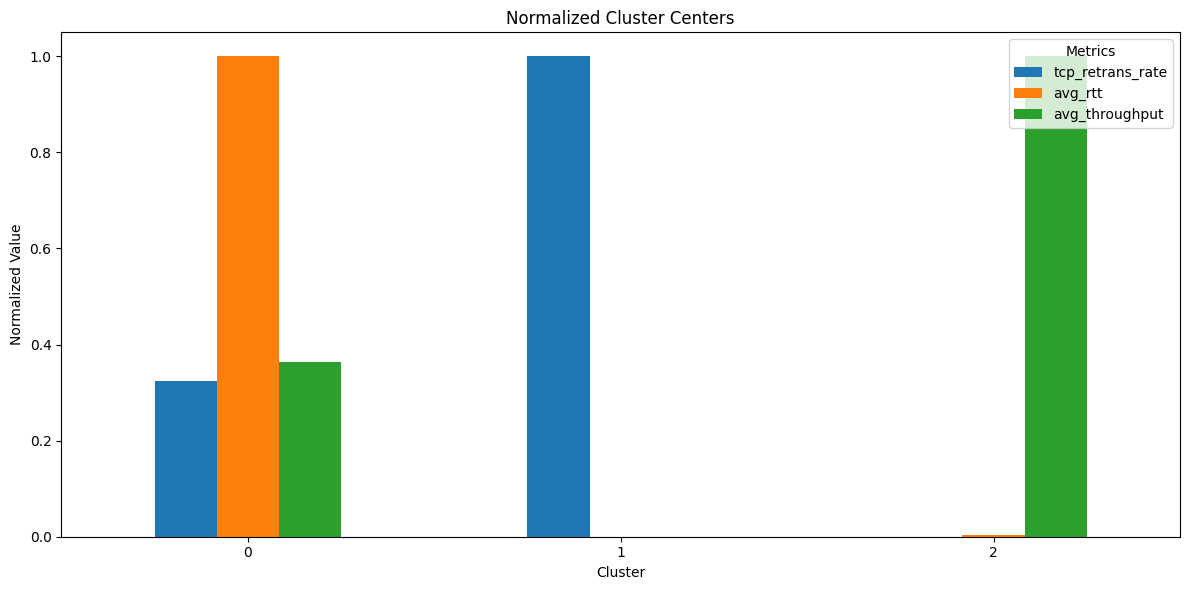


Cluster Interpretations:
--------------------------------------------------
Cluster 0: Average Users: Moderate values across all metrics
Cluster 1: Poor Experience Users: High RTT, low TCP retransmission, low throughput
Cluster 2: High Performance Users: Low RTT, low TCP retransmission, high throughput


In [36]:
# Plot cluster characteristics
plt.figure(figsize=(12, 6))
cluster_centers_normalized = (cluster_centers - cluster_centers.min()) / (cluster_centers.max() - cluster_centers.min())
cluster_centers_normalized.plot(kind='bar', ax=plt.gca())
plt.title('Normalized Cluster Centers')
plt.xlabel('Cluster')
plt.ylabel('Normalized Value')
plt.legend(title='Metrics')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Cluster interpretation

cluster_interpretations = {
    0: "Average Users: Moderate values across all metrics",
    1: "Poor Experience Users: High RTT, low TCP retransmission, low throughput",
    2: "High Performance Users: Low RTT, low TCP retransmission, high throughput"
}

print("\nCluster Interpretations:")
print("-" * 50)
for cluster, interpretation in cluster_interpretations.items():
    print(f"Cluster {cluster}: {interpretation}")


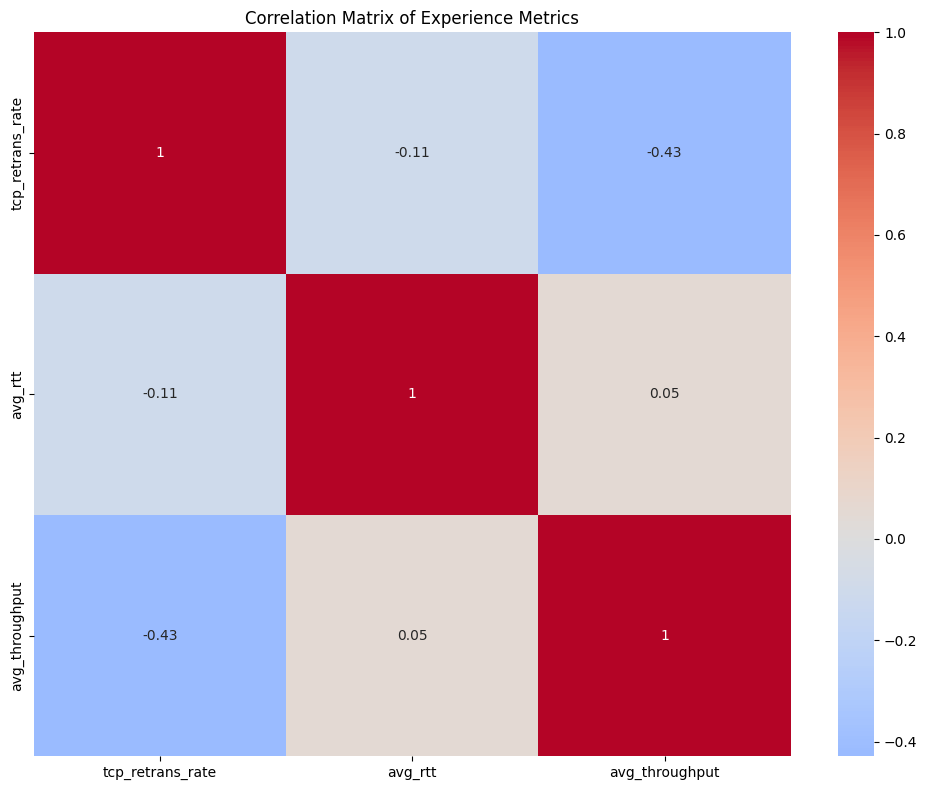

In [37]:
# 4. Additional Analysis: Correlation Matrix
correlation_matrix = df[metrics].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Experience Metrics')
plt.tight_layout()
plt.show()


In [38]:
# 5. Summary Statistics
print("\nSummary Statistics:")
print("-" * 50)
print(df[metrics].describe())



Summary Statistics:
--------------------------------------------------
       tcp_retrans_rate        avg_rtt  avg_throughput
count      1.068570e+05  106857.000000   106857.000000
mean       4.161995e-02      45.407513        5.474971
std        2.820358e-02      33.612924        8.136685
min        8.199949e-08       0.000000        0.000000
25%        5.787915e-03      20.000000        0.046000
50%        5.752183e-02      32.000000        0.105500
75%        5.752183e-02      67.677604        9.463000
max        1.351227e-01     139.194009       23.588500


In [40]:
# 6. Performance Score
# Create a simple performance score based on normalized metrics
df_normalized = (df[metrics] - df[metrics].min()) / (df[metrics].max() - df[metrics].min())
df['performance_score'] = (
    (1 - df_normalized['tcp_retrans_rate']) + 
    (1 - df_normalized['avg_rtt']) + 
    df_normalized['avg_throughput']
) / 3


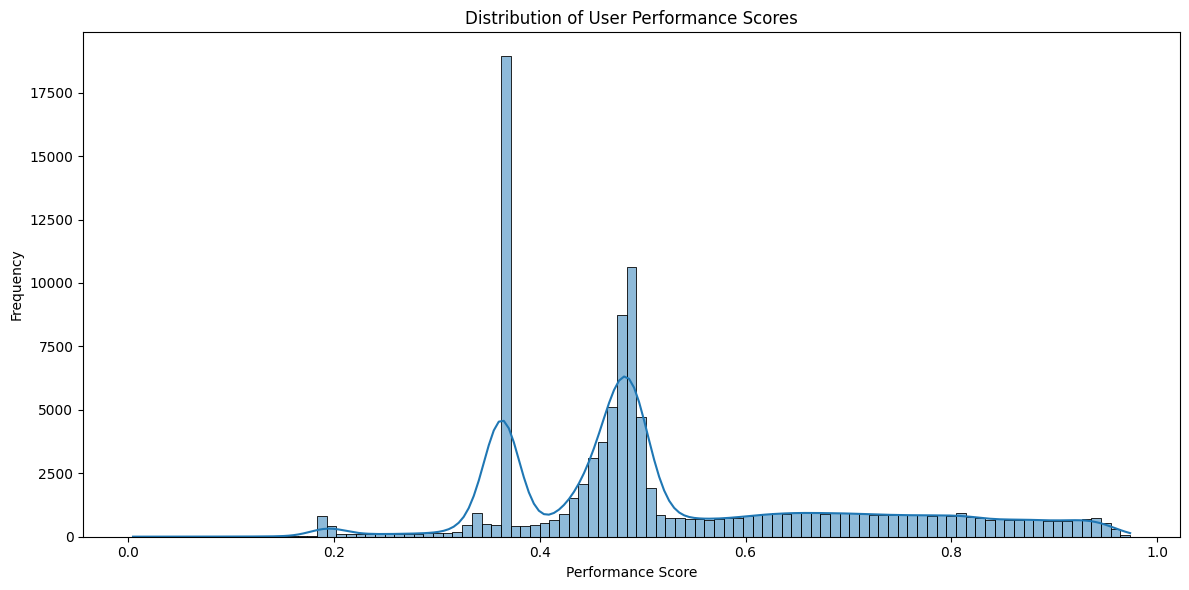

In [41]:
# Plot performance score distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='performance_score', kde=True)
plt.title('Distribution of User Performance Scores')
plt.xlabel('Performance Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [42]:
# Print top performers
print("\nTop 10 Performing Users:")
print("-" * 50)
print(df.nlargest(10, 'performance_score')[['msisdn', 'handset_type', 'performance_score']])


Top 10 Performing Users:
--------------------------------------------------
              msisdn                                      handset_type  \
17344   3.363370e+10                                        Huawei P20   
65853   3.366740e+10                                        Huawei P20   
4424    3.361171e+10  Huawei Mate 10 Pro Porsche Design Huawei Mate 10   
104961  3.378281e+10                  Samsung Galaxy Note 2 (Gt-N7105)   
13144   3.362570e+10                                    Huawei P20 Pro   
15329   3.362952e+10                                    Huawei P20 Pro   
48445   3.366242e+10                           Apple iPhone Xr (A2105)   
1120    3.360390e+10                                    Huawei P20 Pro   
91035   3.375333e+10  Huawei Mate 10 Pro Porsche Design Huawei Mate 10   
12712   3.362504e+10          Samsung Galaxy Grand Prime Ve (Sm-G531X)   

        performance_score  
17344            0.973789  
65853            0.973014  
4424             0.97225